In [1]:
import sys
import subprocess
import os
from collections import defaultdict
import math
import re

import random
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.cluster import KMeans

In [2]:
def error(msg):
    print("*** ERROR ***\n", msg, "\n\n"); 
    input("Press Enter to continue...")
    sys.exit(0)

In [3]:
def invertEdge(E):
    """
    Invert the direction of an edge (V,W) -> (W,V)
    """
    return (E[1], E[0])

def edgeAfter(T , E):    
    """
    Return the next edge after E in T = (V1,V2,V3) with cyclic order
    """
    E1 = (T[0], T[1])
    E2 = (T[1], T[2])
    E3 = (T[2], T[0])
    if E == E1:
        return E2
    if E == E2:
        return E3
    if E == E3:
        return E1
    error(f"error in edgeAfter({T} , {E}), edge not found")

def edge(T, i):
    """
    Return edge number i in the triangle T = (V1, V2, V3)
    """
    return (T[0], T[1]) if i == 0 else ((T[1], T[2]) if i == 1 else ((T[2], T[0]) if i == 2 else error(f"error in edge({T} , {i}), incorrect i value")))

def rotateTriangleStartEdge(T,E):
    """
    Rotate a triangle T=(V1, V2, V3) so that it starts with a given edge E. 
    """
    if (T[0],T[1]) == E:
        return T
    if (T[1],T[2]) == E:
        return (T[1], T[2], T[0])
    if (T[2],T[0]) == E:
        return (T[2], T[0], T[1])
    error(f"error in rotateTriangleStartEdge({T} , {E}), edge not found")   



In [4]:
def getint(str, linenb):
    """Parse an integer from str, abort on error
       - linenb the line number in the file in case of error"""
    try:
        v = int(str)
        return v
    except:
        error(f"cannot convert [{str}] to int at line {linenb + 1}")

def getfloat(str, linenb):
    """Parse a float from str, abort on error
       - linenb the line number in the file in case of error"""
    try:
        v = float(str)
        return v
    except:
        error(f"cannot convert [{str}] to int at line {linenb + 1}")

def parseFaceTag(f, lena, linenb):
    """Parse a 'v/t/n' tag line in the obj file
       - lena = (nb_vertices, nb_textures, nb_normals) the current count of vertices/textures/normals
       - linenb the line number in the file in case of error"""
    x = f.split("/")
    #x = x[:1] # uncomment to remove texture and normals.     
    if len(x) == 0 or len(x) > 3:
        error(f"wrong face index: {f} at line {linenb+1}")
    if len(x) == 1:
        x += ['', '']
    if len(x) == 2:
        x += ['']            
    for i in range(3): 
        if x[i] == '':
            x[i] = -1
        else:
            v = getint(x[i], linenb)        
            if (v == 0):
                error(f"wrong face index: {f} at line {linenb+1} (index 0)")
            x[i] = (v - 1) if v > 0 else lena[i] + v                       
    return tuple(x)

def splitFace(face):
    """Convert a face [f1,f2,f3,..,fn] to a list of triangles [(f1,f2,f3), (f1,f3,f4), (f1,f4,f5),...]"""
    if (len(face) == 3):        
        return [tuple(face)]
    return [tuple(face[:3])] + splitFace([face[0]] + face[2:])

def rotateTriangleToMin(T):
    """
    Rotate a triangle ( (v0,t0,n0), (v1,t1,n1), (v2,t2,n2) ) so that it begins with the
    minimum value of the vi's 
    """
    m = min(T[0][0], T[1][0], T[2][0])
    if (m == T[0][0]):
        return T
    if (m == T[1][0]):
        return (T[1], T[2], T[0])
    if (m == T[2][0]):
        return (T[2], T[0], T[1])

In [9]:
def display3D(list_obj, vertice):
    """
    display a list of mesahes, all sharing the same vertex set 'vertice'.
    Each mesh is displayed with a different color
    """
    # x,y,z arrays for the vertices coords.
    x = np.array([v[0] for v in vertice])
    y = np.array([v[1] for v in vertice])
    z = np.array([v[2] for v in vertice])

    i = []
    j = []
    k = []
    colors = []
    palette = px.colors.qualitative.Dark24
    for n, obj in enumerate(list_obj): 
        colors += [palette[n % 24] for _ in obj]
        i += [u[0][0] for u in obj]
        j += [u[1][0] for u in obj]
        k += [u[2][0] for u in obj]

    fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, opacity=1,facecolor=colors)])
    #fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, opacity=1)])
    fig.update_layout(autosize=False,width=800,height=800)
    fig.show()

In [11]:
def loadObjFile(filename, display = True):    
    """
    Load an .obj file. Return (vertice, texture, normal, obj, tag)
    
    where
    - vertice : list of verticles (as 3D numpy vectors)
    - texture : list of texture coords (as 3D numpy vectors) may be empty
    - normal  : list of normals (as 3D numpy vectors) may be empty    
    - obj: list of object. Each one being a list of triangles indices
    - tag: list of names of each object
    """

    vertice = []
    texture = []
    normal = []
    obj = []
    tag = []
    
    currentobj = []
    currentname = ""
    currenttagline = 0
    currentnb = 0
    
    print(f"Reading file {filename}.\n")
    try:
        with open(filename, "r") as f:
            lines = list(f)
    except:
        error(f"Cannot open file [{filename}]")
        
    for linenb , line in enumerate(lines): 
        l = line.split()
        if len(l) == 0:
            l = [""] # dummy value
        if l[0] == 'v':
            v = tuple(float(v) for v in l[1:])[:3]
            if len(v) != 3:
                error(f"found wrong vertex [v] (not 3 components) at line {linenb+1}")
            vertice.append(np.array(v, dtype=float))
            
        if l[0] == "vt":
            vt = tuple(float(t) for t in l[1:])[:2]
            if len(vt) != 2:
                error(f"found wrong texture coord [vt] (not 2 components) at line {linenb+1}")
            texture.append(np.array(vt, dtype=float))
           
        if l[0] == "vn":
            vn = tuple(float(n) for n in l[1:])[:3]
            if len(vn) != 3:
                error(f"found wrong normal [vn] (not 3 components) at line {linenb+1}")
            normal.append(np.array(vn, dtype=float))
            
        if l[0] == "o" or l[0] == "g" or l[0] == "usemtl":
            if len(currentobj) > 0:                
                print(f"--- found object {len(obj)+1} starting from tag [{currentname}] at line {currenttagline+1} with {len(currentobj)} triangles.")
                obj.append(currentobj)
                tag.append(currentname)
                currentobj = [] 
                currentname = "" if len(l) == 1 else " ".join(l)
                currenttagline = linenb
            else:
                currenttagline = linenb
                if len(l) >1:
                    currentname += " | " + " ".join(l)
                              
        if l[0] == 'f':
            face = [parseFaceTag(x , [len(vertice), len(texture), len(normal)], linenb) for x in l[1:]]
            currentobj += splitFace(face)
            
    if len(currentobj) > 0:                
                print(f"--- found object {len(obj)+1} starting from tag [{currentname}] at line {currenttagline+1} with {len(currentobj)} triangles.")
                obj.append(currentobj)
                tag.append(currentname)              
                
    if (len(obj) == 0):
        error("no faces found in the file !")

    setvi = set()
    setti = set()
    setni = set() 
    for o in obj:
        for T in o:
            for (v,t,n) in T:
                
                if v < 0:
                    error(f"negative vertex index {v} found in face {T}")
                if v >= len(vertice):
                    error(f"vertex index out of bound {v}/{len(vertice)} in face {T}")   
                setvi.add(v)
                
                if (t < -1) or (t >= len(texture)):
                    error(f"texture index out of bound {v}/{len(texture)} in face {T}")  
                setti.add(t)
                
                if (n < -1) or (n >= len(normal)):
                    error(f"normal index out of bound {v}/{len(normal)} in face {T}")  
                setni.add(n)
                
        for i in range(len(o)):
            o[i] = rotateTriangleToMin(o[i])

    if len(setti) > 1 and -1 in setti:
        error(f"Missing texture indexes for some faces (but not all).")  

    if len(setni) > 1 and -1 in setni:
        error(f"Missing normal indexes for some faces (but not all).")  

    print(f"\nTOTAL :")
    print(f"- {len(vertice)} vertices [v]")        
    print(f"- {len(texture)} texture coords [vt]")
    print(f"- {len(normal)} normals [vn]\n")

    if display:
        display3D(obj, vertice)
        
    return vertice, texture, normal, obj, tag

In [13]:
def findBoundingBox(vertice):
    """
    Find the minimum bounding box of a list of vertices
    """
    xmin , ymin, zmin  = vertice[0]
    xmax , ymax, zmax  = vertice[0]
    for (x,y,z) in vertice:
        xmin = min(xmin,x)
        xmax = max(xmax,x)
        ymin = min(ymin,y)
        ymax = max(ymax,y)
        zmin = min(zmin,z)
        zmax = max(zmax,z)        
    return xmin,xmax,ymin,ymax,zmin,zmax


def recenterAndRescale(vertice, ask=True):
    """
    Recenter and rescale a list of vertice so that the bouding box fits in [-1,1]^3
    """
    pr = 2
    xmin,xmax,ymin,ymax,zmin,zmax = findBoundingBox(vertice)    
    print(f"\nBounding box of the model [{round(xmin,pr)},{round(xmax,pr)}]x[{round(ymin,pr)},{round(ymax,pr)}]x[{round(zmin,pr)},{round(zmax,pr)}]")
    ans = "y" if ask==False else input("Do you want to translate/resize the model to fit in [-1,1]^3 (y/N) ?")        
    if len(ans) > 0 and (ans.lower())[0] == "y":        
        cx = (xmin + xmax)/2
        cy = (ymin + ymax)/2
        cz = (zmin + zmax)/2
        mx = (xmax -xmin)/2
        my = (ymax -ymin)/2
        mz = (zmax -zmin)/2
        s = max(mx,my,mz)
        for i in range(len(vertice)):            
            x,y,z  = vertice[i]
            vertice[i] = ((x - cx)/s , (y-cy)/s, (z-cz)/s)                    
        xmin,xmax,ymin,ymax,zmin,zmax = findBoundingBox(vertice)        
    if len(ans) > 0 and (ans.lower())[0] == "y":        
        print(f"New bounding box [{round(xmin,pr)},{round(xmax,pr)}]x[{round(ymin,pr)},{round(ymax,pr)}]x[{round(zmin,pr)},{round(zmax,pr)}]\n")
    return vertice , (xmin,xmax,ymin,ymax,zmin,zmax)


def boundingBoxes(vertice, R):
    """
    Compute the bounding boxes for each object in R
    """
    res = []
    for O in R:
        #iterate over the objects
        vert = []
        for C in O:
            for _,T in C:
                for u, _, _ in T:
                    vert.append(vertice[u])  
        xmin,xmax,ymin,ymax,zmin,zmax = findBoundingBox(vert)
        res.append((xmin,xmax,ymin,ymax,zmin,zmax))
    return res

In [15]:
def dist(A, B):
    """ Compute the euclidian distance beetween 2 vectors """
    return np.linalg.norm(A-B)

def normVec(V):
    """ Return a normalized vector. Does nothing for 0 """
    norm = np.linalg.norm(V)
    return V if (norm == 0) else V/norm

def crossProduct(VA,VB):
    """ Compute the cross product between two vectors """
    return np.cross(VA,VB)

def Vec(VA, VB):
    """ Construct a vector from 2 vertices """
    return VB - VA

In [17]:
def fixNormals(vertice, normal, obj, ask = True, force_regeneration = False):
    """
    Compute the normals is not already present
    """
    if force_regeneration:        
        normal = []
    if len(normal) == 0:                
        print("No normal found. ", end="")
        ans = "y" if ask==False else input("Do you want to compute smooth normals (y/n) ?")       
        if len(ans) > 0 and ((ans.lower())[0] == "y" or (ans.lower())[0] == "o"):        
            # create the normals
            normal = [np.array([0.0, 0.0, 0.0], dtype=float)] * len(vertice)            
            for o in obj:
                for T0,T1,T2 in o:   
                    i0 = T0[0]
                    i1 = T1[0]
                    i2 = T2[0]
                    V0 = Vec(vertice[i1] , vertice[i0])
                    V1 = Vec(vertice[i2] , vertice[i1])
                    V2 = Vec(vertice[i0] , vertice[i2])
                    N0 = crossProduct(V2, V0)
                    N1 = crossProduct(V0, V1)
                    N2 = crossProduct(V1, V2)
                    N = N0 + N1 + N2                    
                    normal[i0] = normal[i0] + N
                    normal[i1] = normal[i1] + N
                    normal[i2] = normal[i2] + N                    
            # insert normal indexes in object
            for o in obj:
                for i in range(len(o)):                        
                    T1, T2, T3 = o[i]
                    o[i] = ((T1[0], T1[1], T1[0]),(T2[0], T2[1], T2[0]),(T3[0], T3[1], T3[0]))
        print(f"done.")

    # normalize the normals, even if we do not recompute them
    for i in range(len(normal)):
        normal[i] = normVec(normal[i])        
        n = np.linalg.norm(normal[i])
        if (n < 0.999) or (n > 1.001):
            print(f"error normal {normal[i]} (index {i}) with norm ={n}")
    print(f"number of normals: {len(normal)}")
    return normal  

In [19]:
def reorderObjectTriangles(obj, strategy = 0):
    """
    Take an object (ie list of triangles) and return a list of chains. 
    """
    availT = obj[:] # list of triangles. Set to none once used. 
    dicedge = defaultdict(lambda: []) # mapping from edge to triangles indexes
    firstTavail = 0 # first triangle available in availT
    nbTavail = len(obj) # number of triangle available in availT
    for i in range(len(obj)):                
        dicedge[edge(obj[i],0)].append(i)
        dicedge[edge(obj[i],1)].append(i)
        dicedge[edge(obj[i],2)].append(i)   
    
    # this method return a triangle index a given edge and mark it as used
    # or return none if no triangle available. 
    def findTriangleWithEdge(E):
        nonlocal availT
        nonlocal dicedge
        nonlocal firstTavail
        nonlocal nbTavail
        L = dicedge[E]
        while(len(L) > 0):
            i = L.pop()
            if availT[i] != None:
                TT = availT[i]
                availT[i] = None
                nbTavail -= 1
                return TT
        return None

    # return the next available triangle or none if all triangles have been used
    def getNextTriangle():
        nonlocal availT
        nonlocal firstTavail
        nonlocal nbTavail        
        if nbTavail == 0:
            return None
        nbTavail -= 1
        while(availT[firstTavail] == None):
            firstTavail += 1            
        T = availT[firstTavail]
        availT[firstTavail] = None              
        return T
        
    R = []    
    inv = 0
    
    while True:        
        # start a new chain 
        T = getNextTriangle()
        if (T == None):
            return R        
        C = [ (None, T) ]        
        E = edge(T, 2) 
        
        while True:
            MAXCHAINLEN = 65535
            if len(C) == MAXCHAINLEN:                
                break    

            nE0 = E
            nE1 = edgeAfter(T, nE0)
            nE2 = edgeAfter(T, nE1)

            # possibly swap nE1 and nE2 depending of strategy
            if (strategy == 1): # other direction
                nE1, nE2 = nE2, nE1                  
            elif (strategy == 2): # alternate direction
                if inv == 0:
                    nE1, nE2 = nE2, nE1 
                inv = 1 - inv
            elif (strategy == 3): #random
                if (np.random.rand() < 0.5):
                    nE1, nE2 = nE2, nE1 
            
            E = nE1
            T2 = findTriangleWithEdge(invertEdge(nE1))
            if T2 == None:
                E = nE2
                T2 = findTriangleWithEdge(invertEdge(nE2))
                if T2 == None:
                    if len(C) > 1:                        
                        break 
                    else:
                        E = nE0
                        T2 = findTriangleWithEdge(invertEdge(nE0))
                        if T2 == None:                            
                            break 
                  
            # got the next link in T2 with shared edge E
            pT = C[-1][1]
            n = None
            if (E == (pT[0], pT[1])):
                if len(C) > 1:
                    error("wrong next edge...")
                n = 2
            if (E == (pT[2], pT[0])):
                n = 0
            if (E == (pT[1], pT[2])):
                n = 1
            if n == None:
                    error("edge not found...")        
            E = invertEdge(E)            
            T = T2
            C.append((n, rotateTriangleStartEdge(T,E)))
            
        if len(C)>1:
            if C[1][0] == 2:
                C[0] = (None , ( C[0][1][1], C[0][1][2], C[0][1][0] )) 
                C[1] = (0, C[1][1])
        R.append(C)

In [25]:
# library used to construct the array: 'pip install icosphere'
# from icosphere import icosphere
# improveCone_vico, _ = icosphere(3)
improveCone_vico = np.array([[ 0.        ,  0.52573111,  0.85065081], [ 0.        , -0.52573111,  0.85065081], [ 0.52573111,  0.85065081,  0.        ], [-0.52573111,  0.85065081,  0.        ],
       [ 0.85065081,  0.        ,  0.52573111], [-0.85065081,  0.        ,  0.52573111], [-0.        , -0.52573111, -0.85065081], [-0.        ,  0.52573111, -0.85065081], [-0.52573111, -0.85065081, -0.        ], [ 0.52573111, -0.85065081, -0.        ], [-0.85065081, -0.        , -0.52573111],
       [ 0.85065081, -0.        , -0.52573111], [ 0.        ,  0.20177411,  0.97943209], [ 0.        , -0.20177411,  0.97943209], [ 0.20177411,  0.73002557,  0.65295472], [ 0.40354821,  0.85472883,  0.32647736], [-0.20177411,  0.73002557,  0.65295472], [-0.40354821,  0.85472883,  0.32647736], 
       [ 0.32647736,  0.40354821,  0.85472883], [ 0.65295472,  0.20177411,  0.73002557], [-0.32647736,  0.40354821,  0.85472883], [-0.65295472,  0.20177411,  0.73002557], [ 0.32647736, -0.40354821,  0.85472883], [ 0.65295472, -0.20177411,  0.73002557], [-0.32647736, -0.40354821,  0.85472883],                  
       [-0.65295472, -0.20177411,  0.73002557], [-0.20177411, -0.73002557,  0.65295472], [-0.40354821, -0.85472883,  0.32647736], [ 0.20177411, -0.73002557,  0.65295472], [ 0.40354821, -0.85472883,  0.32647736], [ 0.20177411,  0.97943209,  0.        ], [-0.20177411,  0.97943209,  0.        ],       
       [ 0.73002557,  0.65295472,  0.20177411], [ 0.85472883,  0.32647736,  0.40354821], [ 0.40354821,  0.85472883, -0.32647736], [ 0.20177411,  0.73002557, -0.65295472], [ 0.73002557,  0.65295472, -0.20177411], [ 0.85472883,  0.32647736, -0.40354821], [-0.73002557,  0.65295472,  0.20177411],
       [-0.85472883,  0.32647736,  0.40354821], [-0.40354821,  0.85472883, -0.32647736], [-0.20177411,  0.73002557, -0.65295472], [-0.73002557,  0.65295472, -0.20177411], [-0.85472883,  0.32647736, -0.40354821], [ 0.85472883, -0.32647736,  0.40354821], [ 0.73002557, -0.65295472,  0.20177411],                 
       [ 0.97943209,  0.        ,  0.20177411], [ 0.97943209,  0.        , -0.20177411], [-0.85472883, -0.32647736,  0.40354821], [-0.73002557, -0.65295472,  0.20177411], [-0.97943209,  0.        ,  0.20177411], [-0.97943209,  0.        , -0.20177411], [-0.        , -0.20177411, -0.97943209],
       [-0.        ,  0.20177411, -0.97943209], [-0.20177411, -0.73002557, -0.65295472], [-0.40354821, -0.85472883, -0.32647736], [ 0.20177411, -0.73002557, -0.65295472], [ 0.40354821, -0.85472883, -0.32647736], [-0.32647736, -0.40354821, -0.85472883], [-0.65295472, -0.20177411, -0.73002557],                 
       [ 0.32647736, -0.40354821, -0.85472883], [ 0.65295472, -0.20177411, -0.73002557], [-0.32647736,  0.40354821, -0.85472883], [-0.65295472,  0.20177411, -0.73002557], [ 0.32647736,  0.40354821, -0.85472883], [ 0.65295472,  0.20177411, -0.73002557], [-0.20177411, -0.97943209, -0.        ],                 
       [ 0.20177411, -0.97943209, -0.        ], [-0.73002557, -0.65295472, -0.20177411], [-0.85472883, -0.32647736, -0.40354821], [ 0.73002557, -0.65295472, -0.20177411], [ 0.85472883, -0.32647736, -0.40354821], [-0.35682209,  0.        ,  0.93417236], [-0.57735027,  0.57735027,  0.57735027],                 
       [ 0.        ,  0.93417236,  0.35682209], [ 0.57735027,  0.57735027,  0.57735027], [ 0.35682209,  0.        ,  0.93417236], [-0.57735027, -0.57735027,  0.57735027], [-0.93417236,  0.35682209,  0.        ], [ 0.        ,  0.93417236, -0.35682209], [ 0.93417236,  0.35682209,  0.        ],                 
       [ 0.57735027, -0.57735027,  0.57735027], [ 0.35682209,  0.        , -0.93417236], [ 0.57735027, -0.57735027, -0.57735027], [ 0.        , -0.93417236, -0.35682209], [-0.57735027, -0.57735027, -0.57735027], [-0.35682209,  0.        , -0.93417236], [ 0.57735027,  0.57735027, -0.57735027],                 
       [ 0.93417236, -0.35682209,  0.        ], [ 0.        , -0.93417236,  0.35682209], [-0.93417236, -0.35682209,  0.        ], [-0.57735027,  0.57735027, -0.57735027]])


def improveCone(center, a, N, eps_start = 0.1, eps_stop = 0.0001):
    """Improve a bounding cone using a greedy decent algorithm"""
    #print(f"start angle ={np.arccos(a) * 180 / np.pi} \t center={center}") 
    eps =eps_start
    L = N.shape[0] # number of normals
    D = improveCone_vico.shape[0] # number of directions to test
    scaling = eps * np.arccos(a) # scaling factor
    
    while(1):        
        # compute the D tentative new centers
        C = center + (scaling * improveCone_vico)
        C /= (np.linalg.norm(C, axis=1).reshape(D,1))

        # make the dot product with all the normals
        # and that the min value among all normals for each tentative center
        MA = np.min(np.dot(C.reshape(1,D,3),N.reshape(L,3,1)).reshape(D,L), axis = 1)
        # find the index of the best tentative center
        i = np.argmax(MA)
        if (MA[i] < a):
            if (eps <= eps_stop):
                #print(f"end angle ={np.arccos(a) * 180 / np.pi} \t center={center}") 
                return (center, a)
            eps /= 2
            scaling = eps * np.arccos(a) # scaling factor
            #print(f"new eps {eps}")
        else:
            # update center and cosine angle        
            center = C[i,:].copy()
            a = MA[i]
            #print(f"  imp: a={a} \t center={center}") 
    

def findCone(normals, ind, tentative_center = None):
    """
    Find the best bounding cone for a subset of normal vectors. 
    input:
    - normals : array of normal vector of shape 
    - ind : list of indices of the set of normal vectors to consider for the bounding cone
    return (center, a) where 
    - center : center vector of the cone
    - a : max cosine value for all the angles between the center vector and the subset of normals 
    """
    L = len(ind)    
    N = np.zeros((L,3), dtype=float)
    for k in range(L):
        N[k,:] = normVec(normals[ind[k]])

    if (tentative_center is not None):
        center = normVec(tentative_center) # use provided tentative_center
    else:
        center = normVec(np.sum(N, axis=0)) # start with the barycenter
        
    A = np.dot(N, center) # compute cosine angle between each normal and the center
    a = np.min(A) #find the minimum value = maximum angle. 
    center, a = improveCone(center, a, N) # try to improve the bounding cone
    return center, a

def cosToAngle(a):
    """convert from cosine to angle in degrees"""
    return np.arccos(a)*180/np.pi

def angleToCos(deg):
    """convert from angle in degrees to cosine"""
    return np.cos(deg*np.pi/180)


In [27]:
def createAdjDic(obj, indT):
    """
    Create a dictionary of tirangle adjacency. Return D where
    D[i] is a list of all indices j such that obj[j] is adjacent to obj[i]
    """
    # create a map from edges to triangles indices
    E = defaultdict(lambda: [])
    for n in indT:
        T = obj[n]
        E[(T[0], T[1])].append(n)
        E[(T[1], T[2])].append(n)
        E[(T[2], T[0])].append(n)
    # now create adjacency dic
    D = defaultdict(lambda: [])
    for n in indT:
        T = obj[n]
        D[n] = E[(T[1],T[0])] + E[(T[2],T[1])] + E[(T[0],T[2])]
        D[n] = np.array(D[n]) # convert to np array for speed.    
    return D
    
def splitConnected(obj, indT):
    """
    split a list 'indT' of triangles indices of 'obj' into a list of list of triangle indices
    where each sublist is a connected set.
    Use greedy exploration
    """
    L = len(indT)
    DA = createAdjDic(obj, indT)
    res = []

    remaining = set(indT) # set of indices not yet classified
    while remaining:
        active = [remaining.pop()] # list of active vertices
        explored = [] # list of explored vertices
        while(active):
            x = active.pop()
            explored.append(x)
            for y in DA[x]:
                if y in remaining:
                    remaining.remove(y)
                    active.append(y)
        res.append(explored) # add the connected component
    return res                

In [67]:
def smooth_meshlets(ind_mesh, cones, obj, Nr, angle_threshold = 0.1, angle_discount = 0.001):
    """
    Apply smoothing to the meshlets
    - ind_mesh: list of list of indices of triangles that describe the meshlets
    - cones : cone: list of pair (C,a) where C is the center vector and a the cosine for the angle of the ocne that obunds the meshlet with same index. 
    - obj : list of triangles
    - Nr :list of normal vectors associated with the triangles
    """
    V = None

    # create a list of all indices 
    all_indices = []
    for sm in ind_mesh:
        all_indices += sm
    
    # create the full adjacency dic
    DA = createAdjDic(obj, all_indices)

    # dictionary that maps a triangle to its meshlet index
    MeshInd = {}
    for n, sm in enumerate(ind_mesh):
        for p in sm:
            MeshInd[p] = n

    def DAN(n, mi):
        """Return a list of all indices which are neighbour of n
            and below gto meshlet mi"""
        return [k for k in DA[n] if (MeshInd[k] == mi)]

    def int_degT(n):
        """return the degree of a triangle inside its own meshlet"""
        return len(DAN(n, MeshInd[n]))

    print("Smoothing meshlets", end="")
    round = 0
    move = 0

    accept_equal_round_max = 1
    accept_equal_round = 0
    accept_equal = False
    
    while True:
        round += 1
        print(".", end="")
        all_indices.sort(key=lambda x: int_degT(x)) # sort triangle indice by increasing inner degree
        improved = False # no improvement found so far
        for x in all_indices:           
            # we iterate over all vertices (starting with those with smallest inner degree). 
            xmi = MeshInd[x] # index of the current meshlet for x            
            Mnei = { MeshInd[k] for k in DA[x] } # set of meshlets adjacent to x
            bestmi = None
            bestdelta = -1 if (accept_equal) else 0
            for ymi in Mnei:
                if ymi != xmi:
                    # we may try changing x from meshlet xmi to ymi
                    delta = len(DAN(x, ymi)) - len(DAN(x, xmi)) # difference of degree of x in the new meshlet vs the current one                    
                    delta += len([1 for z in DAN(x, ymi) if (int_degT(z) < 2)]) - len([1 for z in DAN(x, xmi) if (int_degT(z) < 3)]) # difference for neighours in xmi and ymi
                    if (delta > bestdelta):
                        # check if we stay below the conne threshold
                        a = cones[ymi][1]
                        c, new_a = findCone(Nr, ind_mesh[ymi] + [x], tentative_center = cones[ymi][0])
                        a = cosToAngle(a)
                        new_a = cosToAngle(new_a)
                        if ((delta > 0) and (new_a - a < angle_threshold*a)) or (new_a - a < angle_discount*a):
                            bestdelta = delta
                            bestmi = ymi
                            
            if (bestmi != None):
                # ok, we can perform the swap
                if (bestdelta > 0): improved = True # strict improvement
                move += 1
                # update ind_mesh
                ind_mesh[xmi].remove(x)
                ind_mesh[bestmi].append(x)
                # update meshInd
                MeshInd[x] = bestmi                                
                #print(f"-> moved {x} form meshlet {xmi} to meshlet {ymi}")                
       
        if not improved:
            if (accept_equal == False):                
                accept_equal = True
                accept_equal_round = 0
            else:
                accept_equal_round += 1
                if (accept_equal_round >= accept_equal_round_max):                
                    print(f" done ! {move} performed in {round} passes.")            
                    for k, M in enumerate(ind_mesh):
                        c, ma = findCone(Nr, M, tentative_center = cones[k][0])
                        print(f"meshlet [{k}] with {len(M)} triangles and visibility angle {cosToAngle(ma):.2f} deg -> delta {cosToAngle(ma) - cosToAngle(cones[k][1]):0.4f}")
                        cones[k] = (c,ma)
                    return ind_mesh, cones
        else:
            accept_equal = False
            accept_equal_round = 0
            

    

In [71]:
def createMeshlets(obj, vertices, alpha=1.0, beta=1.0):
    """
    Split a mesh 'obj' with vertex set 'vertice'.
    Return a list of sumeshes (meshlets)
    
    - alpha : coefficient for the importance of normals vs positions
    - beta : factor in front of sqrt(N) for the number of meshlets
    """
    # x,y,z arrays for the vertices coords.
    x = [v[0] for v in vertice]
    y = [v[1] for v in vertice]
    z = [v[2] for v in vertice]

    # i, j, k arrays for the indices of the triangles
    i = [u[0][0] for u in obj]
    j = [u[1][0] for u in obj]
    k = [u[2][0] for u in obj]

    # construct the normals
    Nr = []
    for n in range(len(i)):
        V1 = np.array([x[i[n]], y[i[n]], z[i[n]]])
        V2 = np.array([x[j[n]], y[j[n]], z[j[n]]])
        V3 = np.array([x[k[n]], y[k[n]], z[k[n]]])
        sU = Vec(V1, V2)
        sV = Vec(V1, V3)
        N = crossProduct(sU,sV)
        N = normVec(N)
        Nr.append(N)
    
    center = np.array([ [(x[i[n]] + x[j[n]] + x[k[n]])/3 , (y[i[n]] + y[j[n]] + y[k[n]])/3, (z[i[n]] + z[j[n]] + z[k[n]])/3, alpha*Nr[n][0], alpha*Nr[n][1], alpha*Nr[n][2] ]  for n in range(len(obj))])

    # kmeans
    nbclusters = int(beta*np.sqrt(len(obj)))
    print(f"Splitting the mesh object in {nbclusters} meshlets... ", end="")
    kmeans = KMeans(n_clusters=nbclusters, n_init=20, random_state=1)
    kmeans.fit(center)

    ind_meshlets = [ [] for _ in range(nbclusters) ]
    for n in range(len(obj)):   
        ind_meshlets[kmeans.labels_[n]].append(n)

    dat = []
    for  M in ind_meshlets:
        C, ma = findCone(Nr, M)
        dat.append((C,ma))        
        print(f"meshlet with {len(M)} triangles and visibility angle {cosToAngle(ma):.2f} deg")
    
    smooth_meshlets(ind_meshlets, dat, obj, Nr)
    

    print("done !");

    obj_meshlets = [ [obj[n] for n in  im] for im in ind_meshlets]

    for nn in ind_meshlets:
        R = splitConnected(obj, nn)
        tot = np.sum([len(a) for a in R])
        print(f"{len(nn)} vertices splited in {len(R)} component for a total of {tot} triangle")
        

    camera = normVec(np.array([1.25,1.25,1.25]))
    vis = []
    disp = 0
    tot = 0
    for n in range(nbclusters):
        if (np.dot(dat[n][0], camera) > dat[n][1] - 1):
            vis.append(obj_meshlets[n])
            disp += len(obj_meshlets[n])
        tot += len(obj_meshlets[n])

    print(f"showing {len(vis)}/{len(obj_meshlets)} meshes for {disp}/{tot} = {100*(disp/tot):.2f}%")
    display3D(vis, vertice)
    
    #display3D(obj_meshlets, vertice)
    
    return obj_meshlets , ind_meshlets

    

Reading file buddha.obj.

--- found object 1 starting from tag [ | g Group47867 | usemtl Acier_-_SatinÃ©] at line 10003 with 20000 triangles.

TOTAL :
- 9996 vertices [v]
- 0 texture coords [vt]
- 0 normals [vn]



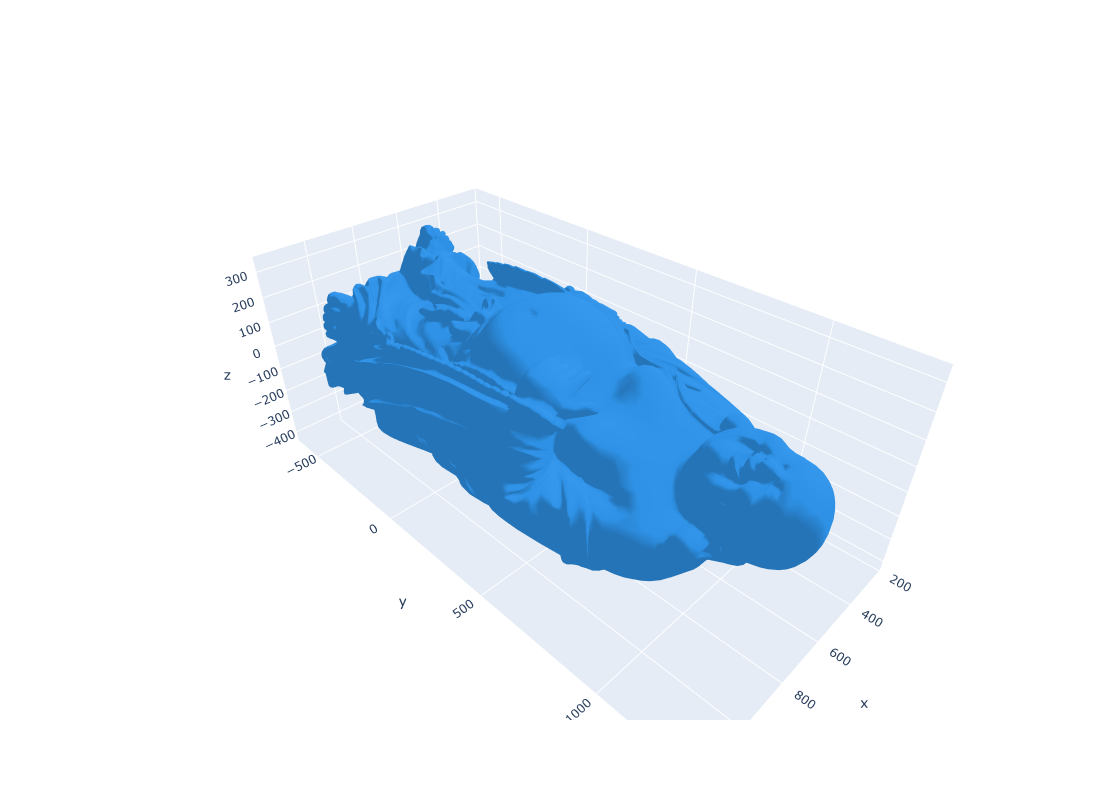

In [95]:
vertice, texture, normal, list_obj, tag = loadObjFile("buddha.obj", display = True)

In [97]:
recenterAndRescale(vertice)


Bounding box of the model [224.32,1168.62]x[-591.35,1291.17]x[-418.61,333.87]


Do you want to translate/resize the model to fit in [-1,1]^3 (y/N) ? y


New bounding box [-0.5,0.5]x[-1.0,1.0]x[-0.4,0.4]



([(-0.2795936555085694, 0.35994197901966724, 0.11600014163808461),
  (0.41076537962835874, -0.3729496806120316, -0.06295290315521358),
  (0.017929453453613447, -0.45599924875868764, -0.32211639164263506),
  (-0.43065350937132585, 0.1077281706736306, -0.133793639826474),
  (0.30496981428759273, 0.2611526914716258, 0.25854420619328944),
  (0.29355242776097135, 0.25840451231497685, 0.25558177762775136),
  (-0.3249779674282434, -0.4314774315956925, 0.2050657746264302),
  (-0.4508647662005158, -0.41045006920760874, -0.08150031673643765),
  (0.17101728552967269, -0.9293089310915861, 0.19157736430920924),
  (-0.1519060213130831, 0.029121486816104138, 0.34869810706162824),
  (0.29130608224610216, -0.9544059167203621, 0.12983876619108906),
  (-0.19143916576989134, -0.4808728450841726, 0.3432599463858341),
  (0.33954056128510113, 0.08680204725071594, 0.23189942943383174),
  (-0.29388431014996813, 0.6302371141407803, -0.16803412779412147),
  (-0.374961477823162, 0.16398029405832298, -0.1700879873

In [99]:
mesha, ind_m = createMeshlets(list_obj[0], vertice, alpha=0.2, beta=0.8)

Splitting the mesh object in 113 meshlets... meshlet with 113 triangles and visibility angle 44.04 deg
meshlet with 179 triangles and visibility angle 61.93 deg
meshlet with 286 triangles and visibility angle 67.40 deg
meshlet with 165 triangles and visibility angle 57.55 deg
meshlet with 252 triangles and visibility angle 66.72 deg
meshlet with 140 triangles and visibility angle 68.16 deg
meshlet with 201 triangles and visibility angle 59.93 deg
meshlet with 192 triangles and visibility angle 45.97 deg
meshlet with 215 triangles and visibility angle 106.06 deg
meshlet with 167 triangles and visibility angle 59.97 deg
meshlet with 135 triangles and visibility angle 67.48 deg
meshlet with 143 triangles and visibility angle 48.89 deg
meshlet with 198 triangles and visibility angle 51.84 deg
meshlet with 188 triangles and visibility angle 72.30 deg
meshlet with 208 triangles and visibility angle 62.59 deg
meshlet with 192 triangles and visibility angle 74.74 deg
meshlet with 212 triangles

KeyboardInterrupt: 

In [84]:
tot = 0
totT = 0
for m in mesha:
    r = stripifyLKH(m)
    tot += len(r)
    totT += len(m)
    
print(f"Total number of triangles:  {totT}")
print(f"Total number of chains:  {tot} \t [{(float(tot)/totT)*100:.1f}%]")

Running LKH... done ! Created 32 chains for 141 triangles 	[22.7%]
Running LKH... done ! Created 36 chains for 178 triangles 	[20.2%]
Running LKH... done ! Created 21 chains for 158 triangles 	[13.3%]
Running LKH... done ! Created 36 chains for 168 triangles 	[21.4%]
Running LKH... done ! Created 34 chains for 114 triangles 	[29.8%]
Running LKH... done ! Created 9 chains for 49 triangles 	[18.4%]
Running LKH... done ! Created 18 chains for 147 triangles 	[12.2%]
Running LKH... done ! Created 30 chains for 119 triangles 	[25.2%]
Running LKH... done ! Created 47 chains for 200 triangles 	[23.5%]
Running LKH... done ! Created 13 chains for 141 triangles 	[9.2%]
Running LKH... done ! Created 18 chains for 123 triangles 	[14.6%]
Running LKH... done ! Created 33 chains for 172 triangles 	[19.2%]
Running LKH... done ! Created 9 chains for 85 triangles 	[10.6%]
Running LKH... done ! Created 35 chains for 126 triangles 	[27.8%]
Running LKH... done ! Created 46 chains for 182 triangles 	[25.3%]


In [85]:
def stripifyLKH(mesh):
    """
    Stripify a mesh
    - take as input a list of triangles 
    - return a list of list of triangle with each sublist being a strip with triangle correctly rotated. 
    """
    IndexToTriangle = mesh
    L = len(IndexToTriangle)

    DA = createAdjDic(IndexToTriangle, range(L))
    
    def isAdjacent(T1, T2):
        """Check if T2 is adjacent to T1"""
        E1 = { (T1[0], T1[1]) , (T1[1], T1[2]), (T1[2], T1[0])}
        E2 = { (T2[0], T2[2]) , (T2[2], T2[1]), (T2[1], T2[0])}
        return (len(E1.intersection(E2)) > 0)

    def rotateTriangleStartVertex(T,V):
        """Rotate a triangle T=(V1, V2, V3) so that it starts with a given vertex V"""
        if V == T[0]:
            return T
        if V == T[1]:
            return (T[1], T[2], T[0])
        if V == T[2]:
            return (T[2], T[0], T[1])
        error(f"error in rotateTriangleStartVertex({T} , {V}), vertex not found")   

    with open("meshlet.par", "w") as f:
        f.write(f"PROBLEM_FILE = meshlet.tsp\n")
        f.write(f"MOVE_TYPE = 5\n")
        f.write(f"PATCHING_C = 3\n")
        f.write(f"PATCHING_A = 2\n")
        f.write(f"RUNS = 8\n")
        f.write(f"OUTPUT_TOUR_FILE = meshlet_res.txt\n")
    
    with open("meshlet.tsp","w") as f:
        f.write(f"NAME: test\n")
        f.write(f"TYPE: TSP\n")
        f.write(f"DIMENSION: {L}\n")
        f.write(f"EDGE_WEIGHT_TYPE: EXPLICIT\n")
        f.write(f"EDGE_WEIGHT_FORMAT: LOWER_DIAG_ROW\n")
        f.write(f"EDGE_WEIGHT_SECTION\n")
        for i in range(L):
            for j in range(i + 1):
                f.write(("0" if j in DA[i] else "1") + " ")
            f.write("\n")
        f.write(f"EOF\n")

    if os.path.exists("meshlet_res.txt"):
        os.remove("meshlet_res.txt")

    print("Running LKH...", end="")
    out = subprocess.check_output(["LKH-2.exe", "meshlet.par"], shell=True)

    if not os.path.exists("meshlet_res.txt"):
        error(f"Error running LKH\n------------\n{out}")

    with open("meshlet_res.txt", "r") as f:
        lines = list(f)

    for n, l in enumerate(lines):
        if l.split()[0] == 'TOUR_SECTION':
            break
            
    tour = []
    for i in range(n + 1,len(lines) - 1):
        v = int(lines[i].split()[0])
        if v < 0: 
            break
        tour.append(v - 1)

    for n in range(len(tour)):    
        tour[n] = IndexToTriangle[tour[n]]

    for n in range(len(tour)-1):        
        if not isAdjacent(tour[n], tour[n+1]):
            tour = tour[(n + 1):] + tour[:(n + 1)]
            break

    sol = []
    cur = [tour[0]]
    for n in range(1,len(tour)):        
        if isAdjacent(tour[n-1], tour[n]):
            cur.append(tour[n])
        else:
            sol.append(cur)
            cur = [tour[n]]
    sol.append(cur)

    # iterate over all chains
    for chain in sol: 
        if (len(chain) > 1):
            if chain[0][2] not in chain[1]:        
                 chain[0] = (chain[0][1], chain[0][2], chain[0][0]) # rotate start of chain        
        for n in range(len(chain) - 1):    
            T1 = chain[n]
            T2 = chain[n+1]        
            # now T1[2] should be in T2. 
            if T1[0] in T2:             
                # V0, V2 commom
                chain[n+1] = rotateTriangleStartVertex(T2, T1[0])  # V0, V2, V'
            else: 
                # V1, V2 commom
                chain[n+1] = rotateTriangleStartVertex(T2, T1[2])  # V2 V1 V'        
          
    print(f" done ! Created {len(sol)} chains for {len(mesh)} triangles \t[{(float(len(sol))/len(mesh))*100:.1f}%]")            
    return sol
    

In [87]:
A = None

In [88]:
def nbCompute(C):
    tot = 0
    for u in C: 
        tot = tot + (2 + len(u))
    return tot
    
def stripify(ob, nbtry = 30):
    totmin = 4*len(ob)
    for i in range(nbtry):    
        if i > 3:
            random.shuffle(ob)    
        C = reorderObjectTriangles(ob, (i%4))
        tot  = nbCompute(C)
        if tot < totmin:
            totmin = tot
            bestC = C
            print(f"{i} total number of triangle point to compute {tot}/{3*len(ob)} for {len(C)} chains\n")
    return bestC

In [89]:
C = stripify(list_obj[0])

0 total number of triangle point to compute 23088/60000 for 1544 chains

1 total number of triangle point to compute 23014/60000 for 1507 chains

